## Analyze time-dependent model runs

In [1]:
%matplotlib notebook
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from oceans import bottomstress
import datapath

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Load model results and data

##### Load results from numerical BBL model 

In [2]:
ds = xr.open_dataset('data/bbl_model_solutions.nc')

##### Load ADCP data

In [3]:
dsadcp = xr.open_dataset(datapath.adcpnc())

##### Load Rover data

In [4]:
# Load data
rover_csv_file = datapath.rover()
df_all = pd.read_csv(rover_csv_file,parse_dates=[5])

# Datetime index
df_all = df_all.set_index('Date_time_R')

# Create u and v components with units m/s
df_all['u'] = df_all['Easting (cm/sec)']/100
df_all['v'] = df_all['Northing (cm/sec)']/100

# mask erroneous points 
# abrupt shift near end of deployment 
bi = ((df_all.index > np.datetime64('2015-06-18T12:00')) &
    (df_all.index < np.datetime64('2015-06-20T00:00')))

df_all['u'][bi] = np.nan
df_all['v'][bi] = np.nan

# select time range
t1 = np.datetime64('2014-10-11T00:00:00')
t2 = np.datetime64('2018-10-17T00:00:00')
df_all = df_all.loc[(df_all.index >= t1) & (df_all.index <= t2)]

# resample and interpolate
df_all_r = df_all.resample('1H').mean()

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Calculate RMSE and sensitivity to roughness length

Calculate root mean squared error at the bottom ADCP bin for different model runs. Find $z_o$ that leads to the minimum RMSE

In [5]:
t1 = 24*12
urmse = np.sqrt(np.mean((ds['usol_obs_all'][t1:-1,0,:]-ds['uobs_subset'][t1:-1,0])**2,axis=0))
vrmse = np.sqrt(np.mean((ds['vsol_obs_all'][t1:-1,0,:]-ds['vobs_subset'][t1:-1,0])**2,axis=0))

ds['speedsol_obs_all'] = np.sqrt(ds['usol_obs_all']**2 + ds['vsol_obs_all']**2)
ds['speedobs_subset'] = np.sqrt(ds['uobs_subset']**2 + ds['vobs_subset']**2)


speedrmse = np.sqrt(np.mean((ds['speedsol_obs_all'][t1:-1,0,:]-
                        ds['speedobs_subset'][t1:-1,0])**2,axis=0))

<IPython.core.display.Javascript object>


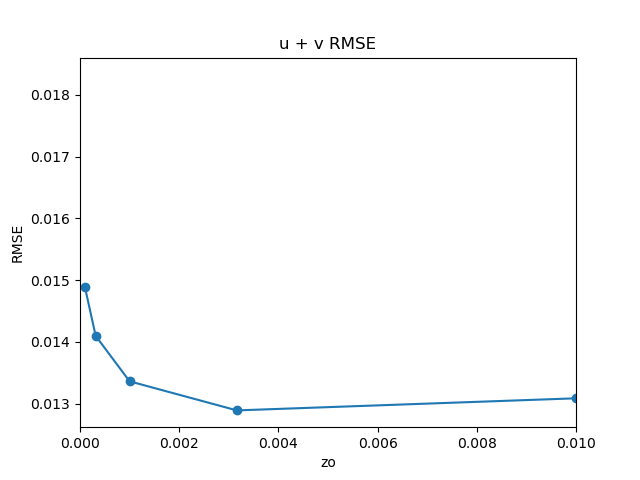

Text(0.5, 1.0, 'u + v RMSE')

In [6]:
plt.figure()
plt.plot(ds['zo'],urmse+vrmse,'-o')
plt.xlim([0,0.01])
plt.xlabel('zo')
plt.ylabel('RMSE')
plt.title('u + v RMSE')

<IPython.core.display.Javascript object>


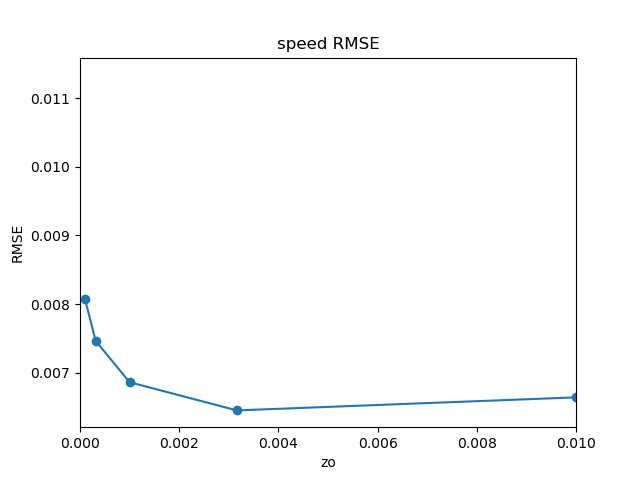

Text(0.5, 1.0, 'speed RMSE')

In [7]:
plt.figure()
plt.plot(ds['zo'],speedrmse,'-o')
plt.xlim([0,0.01])
plt.xlabel('zo')
plt.ylabel('RMSE')
plt.title('speed RMSE')

In [8]:
zoi = int(np.argmin(urmse+vrmse))
zo = np.array(ds['zo'][zoi])

### Calculate modeled friction velocity

In [9]:
# Set up vertical grid for selected zo
zf = ds['zobs'][-1]
nz = 201
z = np.logspace(np.log10(zo),np.log10(zf),nz)
dz = np.diff(z)

# constants
kappa = 0.41
i = 1j

# line up ADCP datetimes with model results
ti0 = 9
ntimes = len(ds['tobs'])
time = dsadcp['time'][ti0:ti0+ntimes]

# Use velocities for selected zo value
u = np.array(ds['usol_all'][t1:,:,zoi])
v = np.array(ds['vsol_all'][t1:,:,zoi])
w = u+i*v

# Calculate friction velocity from bottom grid point of model
ustar = kappa*zo*np.abs(w[:,0])/dz[0]

### Friction velocity estimate from benthic rover observations

In [10]:
# calculate bottom stress and friction velocity for benthic rover
tauxr,tauyr = bottomstress(np.array(df_all['u']),np.array(df_all['v']),1.5,zo=0.003)
taumagr = np.sqrt(tauxr**2 + tauyr**2)
ustarr = np.sqrt(taumagr/1025)

### Plot comparison

<IPython.core.display.Javascript object>


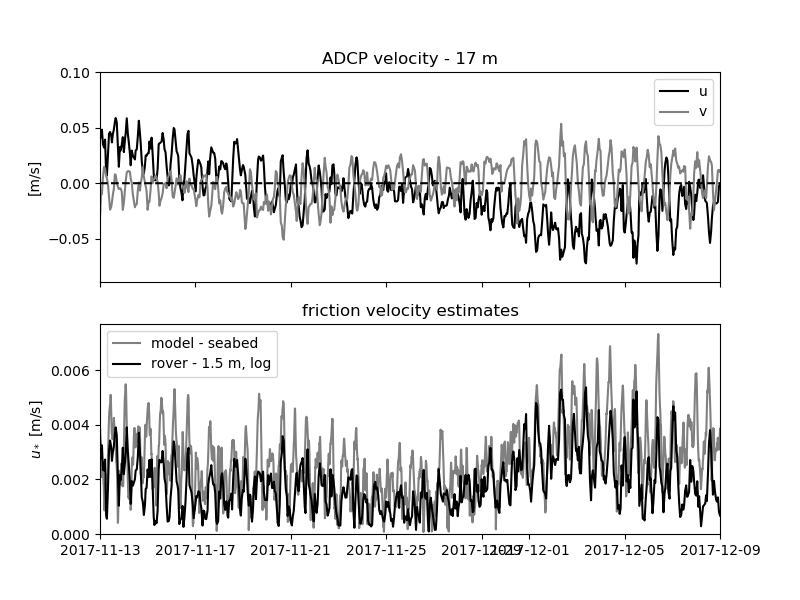

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [11]:
plt.figure(figsize=(8,6))

plt.subplot(211)
plt.plot(df_all.index,df_all['u'],'k-')
plt.plot(df_all.index,df_all['v'],'-',color='gray')
plt.plot(time[t1:],np.zeros(len(time[t1:])),'--',color='k')
xl = plt.xlim([np.datetime64('2017-11-13'),np.datetime64('2017-12-09')])
plt.legend(['u','v'])
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylabel('[m/s]')
plt.title('ADCP velocity - 17 m')

plt.subplot(212)
plt.plot(time[t1:],ustar,'-',color='gray')
plt.plot(df_all.index,ustarr,'k-')
time[t1:]
plt.xlim(xl)
yl = plt.ylim()
plt.ylim([0,yl[1]])
plt.legend(['model - seabed','rover - 1.5 m, log'])
plt.ylabel('$u_*$ [m/s]')
plt.title('friction velocity estimates')

plt.savefig('figures_paper/friction_velocity.pdf')
plt.savefig('figures_paper/friction_velocity.png')